In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
num_qubits = 8

In [3]:
from sklearn.datasets import fetch_california_housing
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

# Load california housing data
housing = fetch_california_housing()
X = housing.data
y = housing.target

# Number of considered samples
desired_num_samples = 1000  # Adjust this as needed

# Randomly sample data points and set the seed to ensure reproducibility
np.random.seed(42)
random_indices = np.random.choice(len(X), desired_num_samples, replace=False)
X_subset = X[random_indices]
y_subset = y[random_indices]

# Split the scaled data into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(X_subset, y_subset, test_size=0.3, random_state=42)
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
Y_train = scaler.fit_transform(Y_train.reshape(-1, 1)).reshape(-1)
Y_test = scaler.transform(Y_test.reshape(-1, 1)).reshape(-1)

In [4]:
from squlearn.encoding_circuit import HubregtsenEncodingCircuit
from squlearn.kernel.matrix import ProjectedQuantumKernel, FidelityKernel

from squlearn.kernel import QSVR

from squlearn.util import Executor
import pennylane as qml
executor = Executor(qml.device("default.qubit"))
executor_shots = Executor(qml.device("default.qubit"),shots=1234)

fm = HubregtsenEncodingCircuit(8,8,3)
pqk = ProjectedQuantumKernel(fm, executor,gamma=0.5)
pqk_shots = ProjectedQuantumKernel(fm, executor_shots,gamma=0.5)
fqk = FidelityKernel(fm, executor)

qsvr_pqk = QSVR(pqk, C=1, epsilon=0.1)
qsvr_pqk_shots = QSVR(pqk_shots, C=1, epsilon=0.1)
qsvr_fqk = QSVR(fqk, C=1, epsilon=0.1)

In [5]:
qsvr_pqk.fit(X_train, Y_train);

In [6]:
qsvr_pqk_shots.fit(X_train, Y_train);

In [7]:

qsvr_fqk.fit(X_train, Y_train);

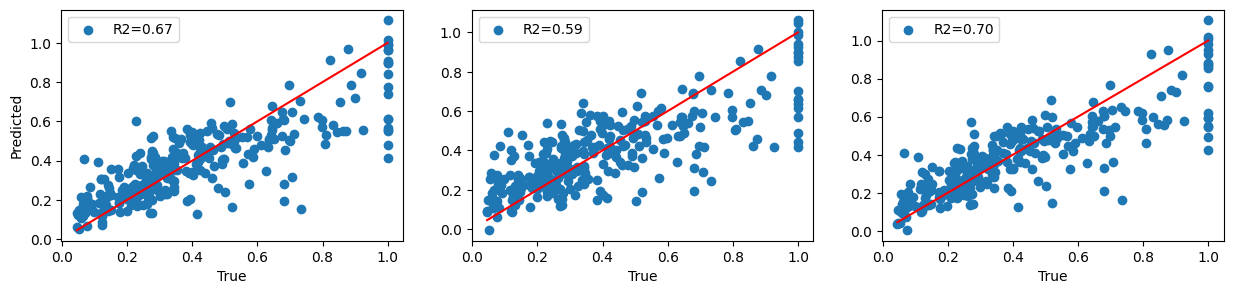

In [8]:
# Plot the results besides each other
fig, axs = plt.subplots(1, 3, figsize=(15, 3))

# Create a list of the models, so we can iterate through them below
models = [
    qsvr_pqk,
    qsvr_pqk_shots,
    qsvr_fqk
    ]

# Iterate through the models and draw a scatter plot
for ax, model in zip(axs, models):
    ax.scatter(Y_test, model.predict(X_test), label=f"R2={model.score(X_test,Y_test):.2f}")
    ax.plot([np.min(Y_test),np.max(Y_test)],[np.min(Y_test),np.max(Y_test)], color='red')
    ax.legend(loc="upper left")
    ax.set_xlabel("True")
    if ax == axs[0]:
        ax.set_ylabel("Predicted")
